# Определение возраста покупателей

# Описание проекта

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:

- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- Контролировать добросовестность кассиров при продаже алкоголя.

# Задача проекта

Постройте модель, которая по фотографии определит приблизительный возраст человека. В вашем распоряжении набор фотографий людей с указанием возраста.

In [1]:
#библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

## Иследовательский анализ данных

In [2]:
df=pd.read_csv('/datasets/faces/labels.csv')
display(df.sample(10))
print('Количество дубликатов: ',df.duplicated().sum())

,file_name,real_age
2014,002014.jpg,23
2913,002913.jpg,17
1746,001746.jpg,27
541,000541.jpg,20
2347,002347.jpg,12
91,000091.jpg,22
3740,003740.jpg,44
1675,001675.jpg,26
4838,004838.jpg,18
1374,001374.jpg,27


Количество дубликатов:  0


In [3]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
real_age,7591.0,31.201159,17.14506,1.0,20.0,29.0,41.0,100.0


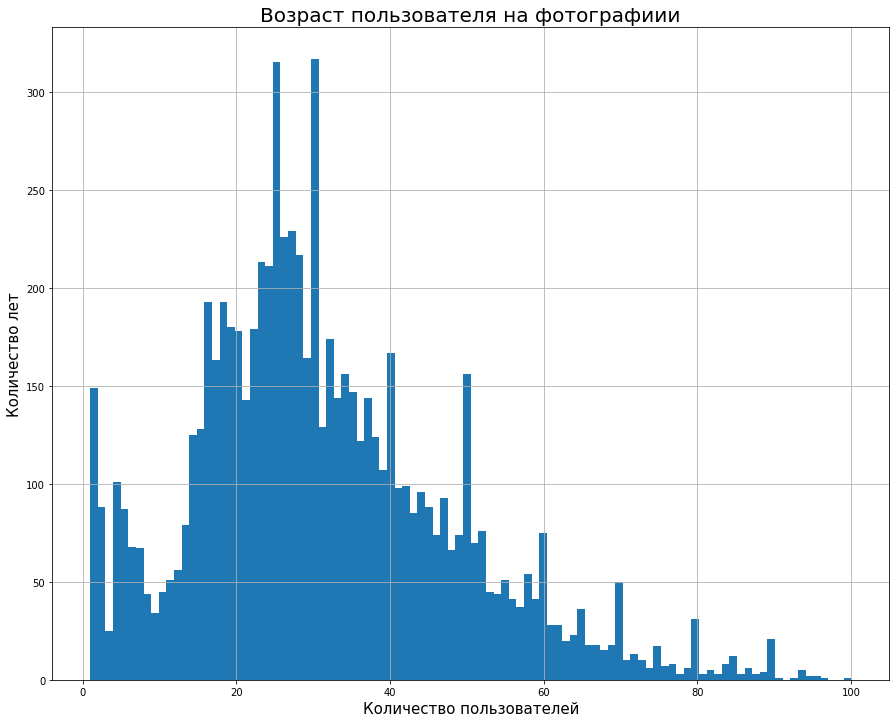

In [7]:
# распределение возраста
df.hist(bins=100, figsize=(15,12))
plt.title('Возраст пользователя на фотографиии',fontsize=20)
plt.xlabel('Количество пользователей',fontsize=15)
plt.ylabel('Количество лет',fontsize=15)
plt.show();

In [5]:
df['real_age'].value_counts().tail(25)

68     15
72     13
85     12
73     10
71     10
77      8
84      8
76      7
74      6
79      6
87      6
94      5
82      5
89      4
86      3
78      3
81      3
83      3
88      3
95      2
96      2
93      1
100     1
91      1
97      1
Name: real_age, dtype: int64

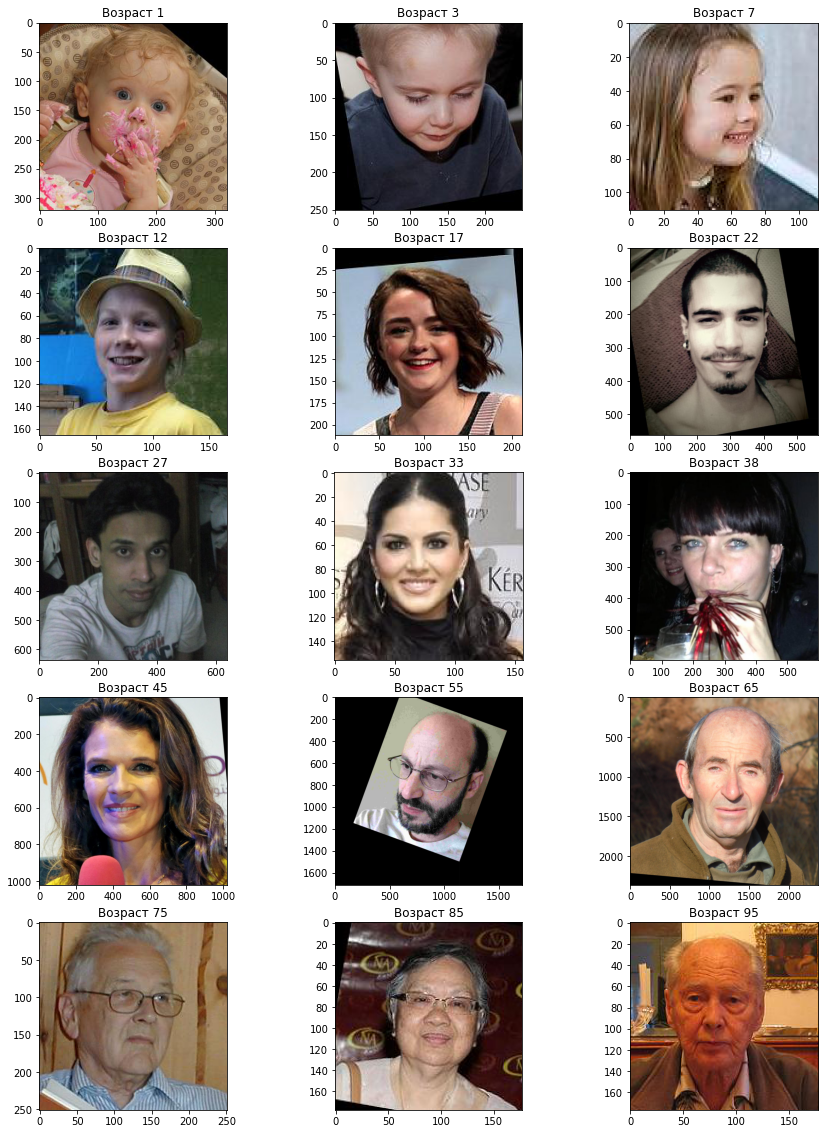

In [6]:
# Вывод по 1 фото на возраст
one_file_age = df.groupby('real_age')['file_name'].min()
# Кол-во лет для вывода
selected_age = [1,3,7,12,17,22,27,33,38,45,55,65,75,85,95]

# Вывод на экран
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(15,20))

n = 0
for ax in axes.flat:
    ax.set(title=(f'Возраст {selected_age[n]}'))
    image = Image.open('/datasets/faces/final_files/' + one_file_age[selected_age[n]])
    ax.imshow(image)
    n += 1
plt.show()

### Вывод по разделу

Датасет содержит набор из  7591 фотографи1

Дубликаты  и пропуски не обнаружены 

Анализ распределение возраста показал,что в датасете присутвуют фотографии людей разных возрастов

- От 1 года до 100 лет

- Средний возраст 31 год,медианный 29 лет

- Оснвная масс фото людей находит в распределении возраста от 20 до 41 года

- Примерно от 55 лет количество фото начинает резко снижаться,в дальнейшем это может негативно повлиять на модель

Анализ фото показал

- Фото имеют разный размер

- Многие фото предобработаны

    Произведена обрезака по центра лица
    
    Изменен угол поворта
    
    
- Так же присувуют фото на которых имееться лицо не одного человека(может негативно повлиять на оммоедль)

- На данных фото все лица отцентрованы

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

import pandas as pd
import numpy as np
from tensorflow.keras.applications.resnet import ResNet5050
from tensorflow.keras.layers import Conv2D, Flatten, Dense, AvgPool2D, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator



def load_train(path):
    datagen = ImageDataGenerator(validation_split=0.25, 
                                 rescale=(1/255),
                                 horizontal_flip=True,
                                 width_shift_range=0.2,
                                 height_shift_range=0.2
                                )
    labels = pd.read_csv(path+'labels.csv')
    train_datagen_flow = datagen.flow_from_dataframe(
                                dataframe=labels,
                                directory=path+'final_files/',
                                x_col='file_name',
                                y_col='real_age',
                                target_size=(224, 224),
                                batch_size=32,
                                class_mode='raw',
                                subset='training',
                                seed=12345)
    print('train shape =', len(train_datagen_flow.filenames))
    return train_datagen_flow

def load_test(path):
    datagen = ImageDataGenerator(validation_split=0.25, rescale=(1/255))
    labels = pd.read_csv(path+'labels.csv')
    test_datagen_flow = datagen.flow_from_dataframe(
                                dataframe=labels,
                                directory=path+'final_files/',
                                x_col='file_name',
                                y_col='real_age',
                                target_size=(224, 224),
                                batch_size=32,
                                class_mode='raw',
                                subset='validation',
                                seed=12345)
    print('test shape =', len(test_datagen_flow.filenames))
    return test_datagen_flow

def create_model(input_shape):
    backbone = ResNet50(input_shape=input_shape,
                        weights='imagenet',
                        include_top=False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='relu'))
    optimizer = Adamax(lr=0.0004)

    model.compile(optimizer=optimizer, loss='mse',
                  metrics=['mae'])
    model.summary()
    return model


def train_model(model, train_datagen, test_datagen, batch_size=16, epochs=15,
               steps_per_epoch=None, validation_steps=None):
    model.fit(train_datagen, 
              validation_data=test_datagen, 
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, shuffle=True)

    return model

```

```
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
resnet50 (Model)             (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                131136    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
=================================================================
Total params: 23,718,913
Trainable params: 23,665,793
Non-trainable params: 53,120
_________________________________________________________________
<class 'tensorflow.python.keras.engine.sequential.Sequential'>
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
Train for 178 steps, validate for 60 steps
Epoch 1/15
2023-07-26 13:37:24.877930: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-07-26 13:37:25.333512: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
178/178 - 106s - loss: 180.6338 - mae: 9.8883 - val_loss: 568.1056 - val_mae: 18.7980
Epoch 2/15
178/178 - 98s - loss: 86.4908 - mae: 6.9965 - val_loss: 409.1274 - val_mae: 15.1220
Epoch 3/15
178/178 - 92s - loss: 64.1050 - mae: 6.1286 - val_loss: 284.8567 - val_mae: 13.0517
Epoch 4/15
178/178 - 93s - loss: 56.0399 - mae: 5.6981 - val_loss: 153.0824 - val_mae: 9.1210
Epoch 5/15
178/178 - 92s - loss: 45.0344 - mae: 5.1595 - val_loss: 94.9633 - val_mae: 7.3578
Epoch 6/15
178/178 - 99s - loss: 38.2676 - mae: 4.7485 - val_loss: 112.0909 - val_mae: 7.9814
Epoch 7/15
178/178 - 100s - loss: 34.4457 - mae: 4.5344 - val_loss: 93.1604 - val_mae: 7.5059
Epoch 8/15
178/178 - 102s - loss: 31.1854 - mae: 4.2858 - val_loss: 69.1858 - val_mae: 6.0284
Epoch 9/15
178/178 - 97s - loss: 27.7773 - mae: 4.0327 - val_loss: 68.4738 - val_mae: 6.1655
Epoch 10/15
178/178 - 99s - loss: 25.7637 - mae: 3.8926 - val_loss: 71.7736 - val_mae: 6.1434
Epoch 11/15
178/178 - 94s - loss: 21.7429 - mae: 3.5653 - val_loss: 94.0545 - val_mae: 7.3591
Epoch 12/15
178/178 - 94s - loss: 21.9368 - mae: 3.5650 - val_loss: 86.1757 - val_mae: 6.7706
Epoch 13/15
178/178 - 100s - loss: 19.6823 - mae: 3.3882 - val_loss: 64.4125 - val_mae: 5.8668
Epoch 14/15
178/178 - 100s - loss: 18.0180 - mae: 3.2543 - val_loss: 118.9362 - val_mae: 8.0220
Epoch 15/15
178/178 - 102s - loss: 19.4288 - mae: 3.3741 - val_loss: 70.9478 - val_mae: 6.0899
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
60/60 - 11s - loss: 70.9478 - mae: 6.0899
Test MAE: 6.0899

```

### Вывод по разделу

Поставленная зада выполнена,метрика МАЕ меньше 8

- Оптимизатор Аdamax

- Параметры Adamax learning_rate=0.0004

- Количество эпох 15

- МАЕ 6.0899

## Анализ обученной модели

Поставленная задача по определению возраста покупателя выполнена

**Исходя из иследовательского анализа был получен следующий вывод**

Датасет содержит набор из  7591 фотографи1

Дубликаты  и пропуски не обнаружены 

Анализ распределение возраста показал,что в датасете присутвуют фотографии людей разных возрастов

- От 1 года до 100 лет

- Средний возраст 31 год,медианный 29 лет

- Оснвная масс фото людей находит в распределении возраста от 20 до 41 года

- Примерно от 55 лет количество фото начинает резко снижаться,в дальнейшем это может негативно повлиять на модель

Анализ фото показал

- Фото имеют разный размер

- Многие фото предобработаны

    Произведена обрезака по центра лица
    
    Изменен угол поворта
    
    
- Так же присувуют фото на которых имееться лицо не одного человека(может негативно повлиять на оммоедль)

- На данных фото все лица отцентрованы

На этапе **Обучние модели** был получен следующий вывод

Было принятно решение использовать имеющуюся в Keras архитектура ResNet50,данная модель была выбрана потому что на основе данной модели решают подобные задачи,нагрузка на вычыслителбкую мощность минимальная

Данная модель показала значение МАЕ = 6.089,что полностью удовлетворяет требования

## Чек-лист

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Исследовательский анализ данных выполнен
- [x]  Результаты исследовательского анализа данных перенесены в финальную тетрадь
- [x]  MAE модели не больше 8
- [x]  Код обучения модели скопирован в финальную тетрадь
- [x]  Результат вывода модели на экран перенесён в финальную тетрадь
- [x]  По итогам обучения модели сделаны выводы